# Capstone Project
## Probabilistic generative models
### Instructions

In this notebook, you will practice working with generative models, using both normalising flow networks and the variational autoencoder algorithm. You will create a synthetic dataset with a normalising flow with randomised parameters. This dataset will then be used to train a variational autoencoder, and you will used the trained model to interpolate between the generated images. You will use concepts from throughout this course, including Distribution objects, probabilistic layers, bijectors, ELBO optimisation and KL divergence regularisers.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports below. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import math

![Flags overview image](data/example_images.png)

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, you will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$. 
* You should use or construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution. 
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$ and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

In [5]:
# Base distribution
#z = tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[0.3,0.3])
loc = np.zeros([1, 2], dtype=np.float32)
basedist_normal = tfd.Normal(loc=loc, scale=.3)
basedist_normal = tfd.Independent(basedist_normal, reinterpreted_batch_ndims=1)
print('batch shape: ', basedist_normal.batch_shape)
print('event shape: ', basedist_normal.event_shape)

batch shape:  (1,)
event shape:  (2,)


In [6]:
prior=tfd.Independent(tfd.Normal(loc=np.zeros([500,2]).astype(np.float32),scale=0.3),reinterpreted_batch_ndims=1)
print(prior.sample().shape)

(500, 2)


(500,) (500,)


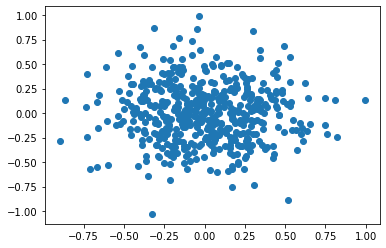

In [7]:
# See what the distribution looks like
plt_sample = basedist_normal.sample()
#Draw 500 samples
x=[]
y=[]

for i in range(500):
    sample = basedist_normal.sample()
    x.append(sample[0,0])
    y.append(sample[0,1])
x = np.array(x)
y = np.array(y)
print(x.shape, y.shape)
plt.scatter(x,y)
plt.show()

In [8]:
# Trial to see how a 2D scale bijector will work
f1 = tfb.ScaleMatvecDiag(scale_diag=[1.,-2.])
c = tf.constant([4.,5.])
tf1=f1(c)
print(tf1)

tf.Tensor([  4. -10.], shape=(2,), dtype=float32)


tf.Tensor([4.0850735], shape=(1,), dtype=float32)


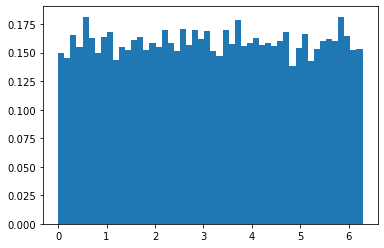

In [9]:
f2 = tfb.ScaleMatvecDiag(scale_diag=[1.,0.5])
th = tfd.Uniform(low=0.0, high=2*math.pi)
th_sampled = th.sample(1)
print(th_sampled)
plt.hist(th.sample(10000), bins=50, density=True)
plt.show()

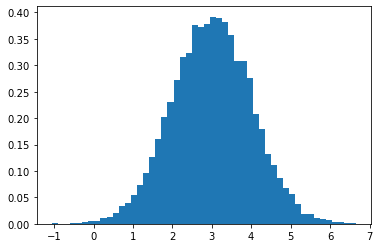

In [10]:
a = (tfd.Normal(loc=3.0,scale=1.0)).sample(10000)
plt.hist(a,bins=50,density=True)
plt.show()

In [11]:
# Define the bijector
class Rotation2D(tfb.Bijector):
    def __init__(self, theta, validate_args=False, name="rotation_2d"):
        th_sample = theta
        self.cos_theta = tf.math.cos(th_sample)
        self.sin_theta = tf.math.sin(th_sample)
        self.event_ndim = 1
        
        super(Rotation2D, self).__init__(
          validate_args=validate_args,
          forward_min_event_ndims=1,
          inverse_min_event_ndims=1,
          name=name,
          is_constant_jacobian=True
        )

    def _forward(self, x):
        batch_ndim = len(x.shape) - self.event_ndim
        x0 = tf.expand_dims(x[..., 0], batch_ndim)
        x1 = tf.expand_dims(x[..., 1], batch_ndim)
        y0 = self.cos_theta * x0 - self.sin_theta * x1
        y1 = self.sin_theta * x0 + self.cos_theta * x1
        return tf.concat((y0, y1), axis=-1)

    def _inverse(self, y):
        batch_ndim = len(y.shape) - self.event_ndim
        y0 = tf.expand_dims(y[..., 0], batch_ndim)
        y1 = tf.expand_dims(y[..., 1], batch_ndim)
        x0 = self.cos_theta * y0 + self.sin_theta * y1
        x1 = -self.sin_theta * y0 + self.cos_theta * y1
        return tf.concat((x0, x1), axis=-1)

    def _forward_log_det_jacobian(self, x):
        print(x)
        return tf.constant(0., x.dtype)

In [12]:
rot=Rotation2D(theta=tfd.Uniform(low=0.0, high=2*math.pi).sample())
pt = tf.constant([2.,2.])
pt_rot = rot(pt)
print(pt_rot)

tf.Tensor([-2.1660368 -1.8188689], shape=(2,), dtype=float32)


In [13]:
class f3(tfb.Bijector):
    def __init__(self, validate_args=False, name="f3"):
        
        self.a = tfd.Normal(loc=3.0,scale=1.0)
        #print("a=",self.a)
        self.event_ndim = 1
        
        super(f3, self).__init__(
          validate_args=validate_args,
          forward_min_event_ndims=1,
          inverse_min_event_ndims=1,
          name=name,
          is_constant_jacobian=True
        )

    def _forward(self, x):
        batch_ndim = len(x.shape) - self.event_ndim
        x0 = tf.expand_dims(x[..., 0], batch_ndim)
        x1 = tf.expand_dims(x[..., 1], batch_ndim)
        #print("x0=",x0,"x1=",x1)
        y0 = x0
        y1 = x1 + self.a.sample()*(x0*x0) # z2+a*z1*z1
        #print("y1=",y1)
        return tf.concat((y0, y1), axis=-1)

    def _inverse(self, y):
        batch_ndim = len(y.shape) - self.event_ndim
        y0 = tf.expand_dims(y[..., 0], batch_ndim)
        y1 = tf.expand_dims(y[..., 1], batch_ndim)
        x0 = y0
        x1 = y1 - self.a.sample()*(x0*x0)
        return tf.concat((x0, x1), axis=-1)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)

In [14]:
print(tf.math.log(1.))
print(tf.constant(0.))

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [16]:
class final_bijector(tfb.Bijector):
    
    def __init__(self, validate_args=False, name='final_bijector'):
        
        self.a = tfd.Normal(loc=3.0,scale=1.0)
        self.th = tfd.Uniform(low=0.0, high=math.pi)
        self.bijectors = [
            tfb.ScaleMatvecDiag(scale_diag=[1.,-2.]),
            tfb.ScaleMatvecDiag(scale_diag=[1.,0.5]),
            f3(self.a.sample()),
            Rotation2D(self.th.sample()),
            tfb.Tanh()
        ]
        self.forward_bijector = tfb.Chain(list(reversed(self.bijectors)))
        self.inverse_bijector = tfb.Invert(self.forward_bijector)
        
        super(final_bijector, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)
    
    def _forward(self,x):
        x = tf.cast(x, tf.float32)
        return self.forward_bijector(x)

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return self.inverse_bijector(y)
    
    
    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x,tf.float32)
        #return tfb.Chain.forward_log_det_jacobian(x=self._forward(x), event_ndims=2)
        #return -self._inverse_log_det_jacobian(self._forwrd(x))
        return tf.constant(0.,x.dtype)
    
    #def _inverse_log_det_jacobian(self, y):
        #y = tf.cast(y,tf.float32)
        #return tfb.Chain.inverse_log_det_jacobian(self._forward(x), event_ndims=2)
        #return -tf.math.log(y) - tf.math.log(1-y)

In [17]:
def get_base_dist():
    loc = np.zeros([1, 2], dtype=np.float32)
    basedist_normal = tfd.Normal(loc=loc, scale=.3)
    return tfd.Independent(basedist_normal, reinterpreted_batch_ndims=1)

In [18]:
# TransformedDistribution object
fin_bij = final_bijector()
transformed_dist = tfd.TransformedDistribution(get_base_dist(), fin_bij)
print(transformed_dist)

tfp.distributions.TransformedDistribution("final_bijectorIndependentNormal", batch_shape=[1], event_shape=[2], dtype=float32)


In [19]:
tf.squeeze(transformed_dist.sample(500)).shape

TensorShape([500, 2])

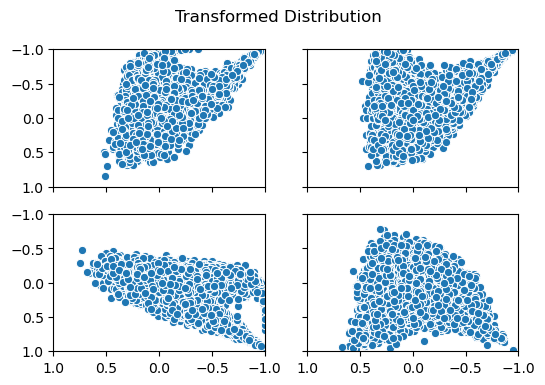

In [20]:
import seaborn as sns
x=[]
y=[]
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, sharey=True,dpi=100)
plt.suptitle("Transformed Distribution")

for sample, ax in zip(range(4),[ax1,ax2,ax3,ax4]):
    
    fin_bij = final_bijector()
    transformed_dist = tfd.TransformedDistribution(get_base_dist(), fin_bij)
    sample = tf.squeeze(transformed_dist.sample(5000))
    sns.scatterplot(x=sample[:,0],y=sample[:,1],ax=ax)
    ax.set_xlim(1,-1)
    ax.set_ylim(1,-1)

plt.show()

## 2. Create the image dataset
* You should now use your random normalising flow to generate an image dataset of contour plots from your random normalising flow network. 
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters. 
  * You may find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot. 
* Your dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help you to generate the dataset. 
  * This function creates a numpy array for an image of the contour plot for a given set of density values Z. Feel free to choose your own options for the contour plots.
* Display a sample of 20 images from your generated dataset in a figure.

In [21]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [22]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

In [23]:
print(transformed_dist)
print(get_densities(transformed_dist).shape)

tfp.distributions.TransformedDistribution("final_bijectorIndependentNormal", batch_shape=[1], event_shape=[2], dtype=float32)
(1, 100, 100)


In [24]:
dataset = np.zeros([1500,36,36,3])

for i in range(1500):
    base_dist = get_base_dist()
    fin_bij = final_bijector()
    transformed_dist = tfd.TransformedDistribution(base_dist, fin_bij)
    density = get_densities(transformed_dist)
    dataset[i] = get_image_array_from_density_values(density[0])

In [25]:
dataset.shape

(1500, 36, 36, 3)

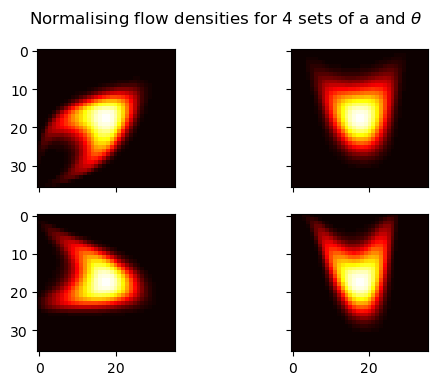

In [26]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, sharey=True,dpi=100)

plt.suptitle("Normalising flow densities for 4 sets of a and "+r'$\theta$')
ax1.imshow(dataset[0].astype(int))
ax2.imshow(dataset[1].astype(int))
ax3.imshow(dataset[2].astype(int))
ax4.imshow(dataset[3].astype(int))
plt.show()

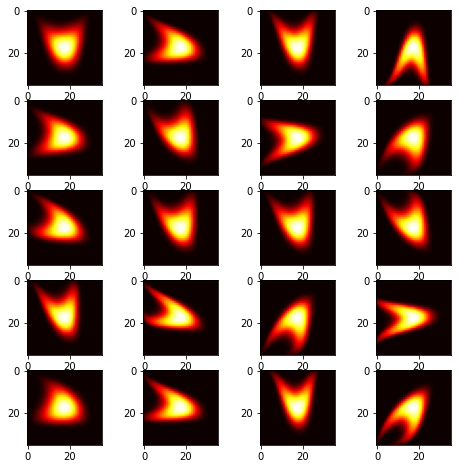

In [27]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = dataset[i].astype(int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [28]:
print(dataset.shape)
print(type(dataset))

(1500, 36, 36, 3)
<class 'numpy.ndarray'>


In [29]:
def modifyimages(image, image_out):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image_out = image_out/255.0
    return (image, image_out)

def map_images(dataset):
    return dataset.map(modifyimages)

In [30]:
def create_dataset(data):
    return tf.data.Dataset.from_tensor_slices((data,data))

In [31]:
dataset_obj = create_dataset(dataset)
print(dataset_obj)

<TensorSliceDataset shapes: ((36, 36, 3), (36, 36, 3)), types: (tf.float64, tf.float64)>


In [32]:
dataset_obj = map_images(dataset_obj)
print(dataset_obj)

<MapDataset shapes: ((36, 36, 3), (36, 36, 3)), types: (tf.float32, tf.float64)>


In [33]:
dataset_obj = dataset_obj.shuffle(1500)
train_dataset = dataset_obj.take(1200)
test_dataset = dataset_obj.skip(1200)
train_dataset = train_dataset.batch(20,drop_remainder=True)

print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None))
(TensorSpec(shape=(36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(36, 36, 3), dtype=tf.float64, name=None))


In [34]:
test_dataset = test_dataset.batch(20,drop_remainder=True)

## 4. Build the encoder and decoder networks
* You should now create the encoder and decoder for the variational autoencoder algorithm.
* You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.
* Print the model summary for the encoder and decoder networks.

In [35]:
latent_size=2
prior=tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size),scale_diag=tf.ones(latent_size))

In [36]:
encoder=tf.keras.models.Sequential([
    tf.keras.layers.Input((36,36,3)),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2),padding='same'),
    tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2),padding='same'),
    tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2),padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior,weight=1)
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [37]:
decoder=tf.keras.models.Sequential([
    tf.keras.layers.Input(latent_size),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Reshape((2,2,1)),
    tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((3,3)),
    tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='valid'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16,(2,2),activation='relu',padding='valid'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(3,(3,3),activation='sigmoid',padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(tfpl.IndependentBernoulli.params_size((36,36,3))),
    tfpl.IndependentBernoulli(event_shape=(36,36,3),convert_to_tensor_fn=tfp.distributions.Distribution.mean,)
])

In [38]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0

## 5. Train the variational autoencoder
* You should now train the variational autoencoder. Build the VAE using the `Model` class and the encoder and decoder models. Print the model summary.
* Compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation Datasets.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [39]:
vae=tf.keras.models.Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs))
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 36, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 36, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 8)           0     

In [40]:
def log_loss(x_true,x):
    return -tf.reduce_sum(x.log_prob(x_true))

In [41]:
vae.compile(loss=log_loss,optimizer=tf.keras.optimizers.Adam(),metrics=["mae"])

In [42]:
history=vae.fit(train_dataset,epochs=50,validation_data=test_dataset,verbose=1,shuffle=True)

Epoch 1/50
60/60 [==============================] - 8s 113ms/step - loss: 17239.4032 - mae: 0.0911 - val_loss: 11862.4941 - val_mae: 0.0484
Epoch 2/50
60/60 [==============================] - 6s 104ms/step - loss: 11814.5185 - mae: 0.0473 - val_loss: 11875.8896 - val_mae: 0.0497
Epoch 3/50
60/60 [==============================] - 6s 105ms/step - loss: 11773.5868 - mae: 0.0475 - val_loss: 11686.3379 - val_mae: 0.0471
Epoch 4/50
60/60 [==============================] - 7s 108ms/step - loss: 11642.3845 - mae: 0.0464 - val_loss: 11046.8730 - val_mae: 0.0407
Epoch 5/50
60/60 [==============================] - 7s 105ms/step - loss: 10953.3968 - mae: 0.0394 - val_loss: 10224.1152 - val_mae: 0.0335
Epoch 6/50
60/60 [==============================] - 6s 105ms/step - loss: 9971.5616 - mae: 0.0293 - val_loss: 9608.0244 - val_mae: 0.0244
Epoch 7/50
60/60 [==============================] - 6s 104ms/step - loss: 9549.3457 - mae: 0.0237 - val_loss: 9324.4580 - val_mae: 0.0210
Epoch 8/50
60/60 [======

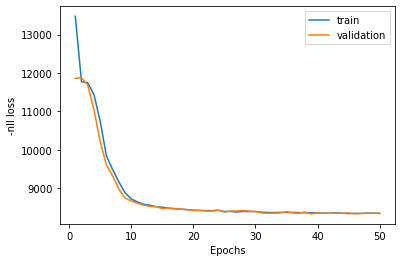

In [43]:
plt.plot(range(1,51),history.history["loss"],label="train")
plt.plot(range(1,51),history.history["val_loss"],label="validation")
plt.xlabel("Epochs")
plt.ylabel("-nll loss")
plt.legend()
plt.show()

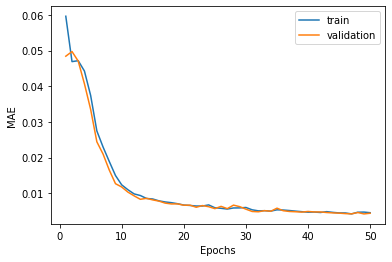

In [44]:
plt.plot(range(1,51),history.history["mae"],label="train")
plt.plot(range(1,51),history.history["val_mae"],label="validation")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## 6. Use the encoder and decoder networks
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

In [45]:
latent_samples=np.empty(shape=(0,2))

for i,data in enumerate(train_dataset):
    #rint(data)
    latent_sample=encoder(data[0]).sample()
    latent_samples=np.concatenate([latent_samples,latent_sample],axis=0)

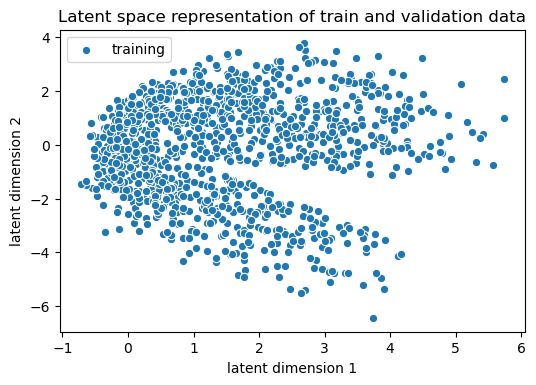

In [46]:
fig=plt.figure(dpi=100)
plt.title("Latent space representation of train and validation data")
sns.scatterplot(x=latent_samples[:,0],y=latent_samples[:,1],label="training")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")
plt.show()

In [47]:
def reconstruct(encoder, decoder, batch_of_images):
    encodings = encoder(batch_of_images).mean()
    decoding_dist = decoder(encodings)
    return decoding_dist.mean()

In [48]:
dataset.shape

(1500, 36, 36, 3)

In [49]:
dataset_sample = tf.data.Dataset.from_tensor_slices(dataset[0:1000,:])
dataset_sample = dataset_sample.map(lambda x: x/255)
print(dataset_sample.element_spec)

TensorSpec(shape=(36, 36, 3), dtype=tf.float64, name=None)


In [50]:
n_reconstructions = 1000
num_test_files = 1000
test_ds_for_reconstructions = dataset_sample
for all_test_images in test_ds_for_reconstructions.batch(num_test_files).take(1):
    all_test_images_np = all_test_images.numpy()
example_images = all_test_images_np[np.random.choice(num_test_files, n_reconstructions, replace=False)]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

In [51]:
print(reconstructions.shape)

(1000, 36, 36, 3)


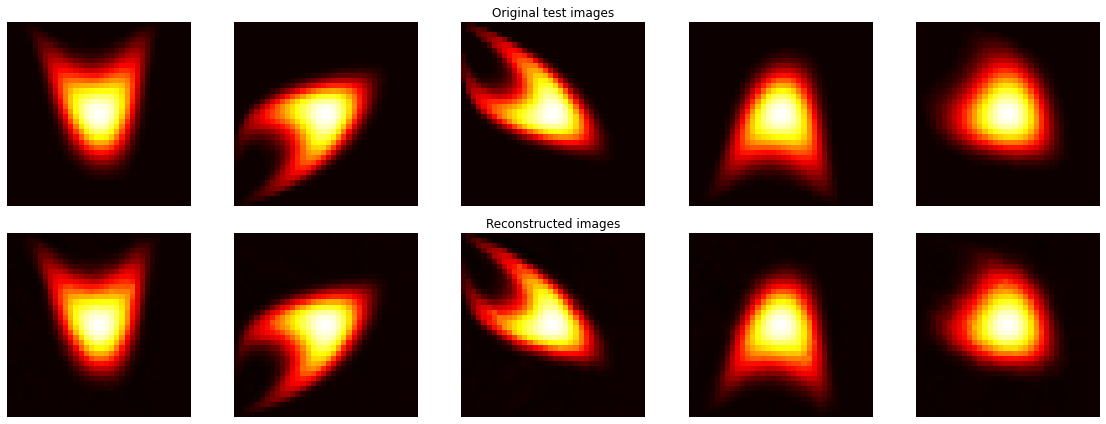

In [52]:
f, axs = plt.subplots(2,5 , figsize=(16, 6))
axs[0, 5 // 2].set_title("Original test images")
axs[1, 5 // 2].set_title("Reconstructed images")
for j in range(5):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
    
plt.tight_layout();

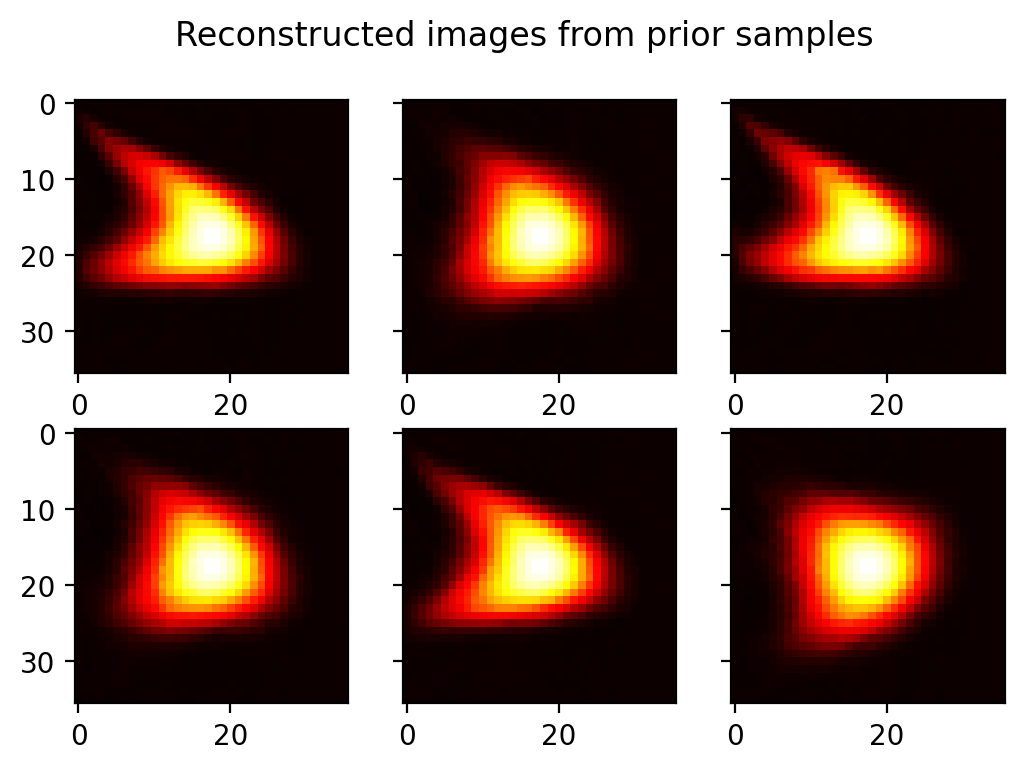

In [53]:
prior_samples = get_base_dist().sample(6)
fig,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,sharey=True,dpi=200)

for sample,ax in zip(prior_samples,[ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.imshow(tf.squeeze(decoder(tf.reshape(sample,(1,2))).mean()))
    
plt.suptitle("Reconstructed images from prior samples")
plt.show()

## Make a video of latent space interpolation (not assessed)
* Just for fun, you can run the code below to create a video of your decoder's generations, depending on the latent space.

In [54]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

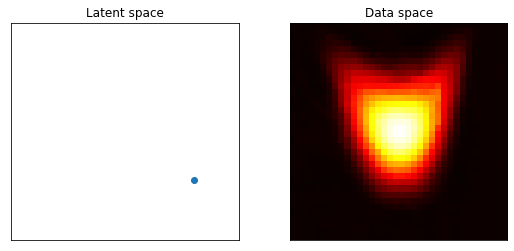

In [55]:
# Create the animation

a = get_animation(latent_size, decoder, interpolation_length=200)
HTML(a.to_html5_video())